In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

#import matplotlib
#matplotlib.use('agg')
#import matplotlib.pyplot as plt 

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.show()

import tensorflow as tf
import sys, os, math
import gezi, melt
import numpy as np

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt'
image_model_name='InceptionResnetV2'
model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell/'
if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path, 
                                      model_name=image_model_name,
                                      feature_name=melt.image.get_features_name(image_model_name))
else:
  image_model = None
predictor = melt.Predictor(model_dir)

import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.2.0-rc0


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


ENCODE_UNK 1


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt


restore image var from InceptionResnetV2 /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt duration: 3.51864385605


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model/showattentell/model.ckpt-2.9-12000


restore meta grpah and model ok /home/gezi/new/temp/image-caption/ai-challenger/model/showattentell/model.ckpt-2.9-12000 duration: 20.9045000076


In [ ]:
def predict(image_name, num_show=1):
  image_path = os.path.join(image_dir, image_name)
  
  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    return 

  img = melt.read_image(image_path)
  feature = image_model.gen_feature(img) if image_model is not None else img
  print(feature)
  timer = gezi.Timer()
  graph = predictor.graph
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          graph.get_collection('feed')[0] : feature
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          graph.get_collection('feed')[0] : feature,
                                          graph.get_collection('beam_search_input_feed')[0] : input_feed,
                                          graph.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=ids2text.end_id(), 
                                   max_words=decode_max_words, 
                                   length_normalization_factor=1.)


  for i, beam in enumerate(beams):
    print(i, beam.words, ids2text.ids2text(beam.words), math.exp(beam.score))

    # Plot images with attention weights
    words = beam.words    
    img = ndimage.imread(image_path)
    
    num_features = melt.image.get_num_features(image_model_name)
    dim = int(np.sqrt(num_features))
    #print('dim:', dim)

    n_words = len(words)
    n_words += 1 #for ori image
    w = np.round(np.sqrt(n_words))
    h = np.ceil(np.float32(n_words) / w)
    
    print(n_words, w, h)
            
    plt.subplot(w, h, 1)
    plt.imshow(img)
    plt.axis('off')

    #img = scipy.misc.imresize(img, (dim, dim))  

    #smooth = True  #TODO smooth = Ture seems not work not back ground pic
    smooth = False
    if i < 10:
      for j in range(len(words)):
        plt.subplot(w, h, j + 2)
        lab = pinyin.Convert(ids2text.vocab.key(words[j]).decode('utf8').encode('gbk'))
        lab += '(%0.2f)'%math.exp(beam.logprobs[j])
        plt.text(0, 1, lab, backgroundcolor='white', fontsize=10)
        plt.text(0, 1, lab, color='black', fontsize=10)
        plt.imshow(img)
        if smooth:
          alpha_img = skimage.transform.pyramid_expand(beam.alignments_list[j].reshape(dim, dim), upscale=16, sigma=20)
        else:
          alpha_img = skimage.transform.resize(beam.alignments_list[j].reshape(dim, dim), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
      plt.show()
      #plt.savefig('test%d.pdf'%i)

    #print('beam search using time(ms):', timer.elapsed_ms())

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:9dac10ad78a4d03d135ff241db55b77d193adbe0
[[ 0.          0.          0.         ...,  0.          0.187511
   0.32138079]]
0 [10, 43, 154, 1, 22, 24, 2, 52, 5, 1, 284, 29, 9] 一个/戴着/墨镜/的/女人/走/在/道路/上/的/汽车/旁/</S> 0.63819189392
14 4.0 4.0


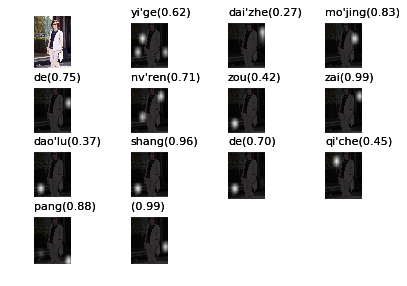

1 [10, 43, 154, 1, 22, 24, 2, 156, 1, 52, 5, 9] 一个/戴着/墨镜/的/女人/走/在/平坦/的/道路/上/</S> 0.626071158312
13 4.0 4.0


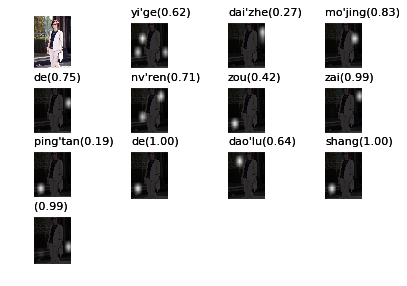

2 [52, 5, 24, 3, 10, 42, 136, 3, 50, 1, 22, 9] 道路/上/走/着/一个/右手/拎/着/包/的/女人/</S> 0.596303304654
13 4.0 4.0


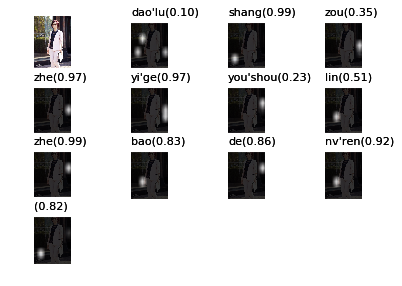

In [ ]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:')
  image_name = image_name.strip()
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'
  predict(image_name)